In [70]:
import numpy as np
import pandas as pd
import json
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Embedding, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tensorflow.keras.layers import Bidirectional, GlobalMaxPooling1D

In [71]:
np.random.seed(42)
tf.random.set_seed(42)

In [72]:
# Load GloVe embeddings
def load_glove_embeddings(glove_path, embedding_dim=300):
    print(f"Loading GloVe embeddings from {glove_path}...")
    word_to_vec = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype=np.float32)
            word_to_vec[word] = vector
    print(f"Loaded {len(word_to_vec)} word vectors")
    return word_to_vec

# Load and preprocess text data
def load_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

def preprocess_data(df):
    df = df[['message', 'sender_annotation']].copy()
    df['sender_annotation'] = df['sender_annotation'].astype(int)
    return df

def convert_text_to_embedding(text, glove_embeddings, embedding_dim=300, max_seq_len=50):
    tokens = text.split()
    embeddings = []
    
    for word in tokens:
        if word in glove_embeddings:
            embeddings.append(glove_embeddings[word])
        else:
            embeddings.append(np.zeros(embedding_dim))

    if len(embeddings) > max_seq_len:
        embeddings = embeddings[:max_seq_len]
    else:
        embeddings += [np.zeros(embedding_dim)] * (max_seq_len - len(embeddings))

    return np.array(embeddings, dtype=np.float32)

In [73]:
# nlp = spacy.load("en_core_web_sm")

# def tokenize_text(text):
#     return [token.text.lower() for token in nlp(text)]

# MAX_SEQ_LEN = 50

# def convert_text_to_embedding(text, glove_embeddings, embedding_dim=300, max_seq_len=100):
#     tokens = text.split()
#     embeddings = [glove_embeddings[word] if word in glove_embeddings else np.zeros(embedding_dim) for word in tokens]


#     if len(embeddings) > max_seq_len:
#         embeddings = embeddings[:max_seq_len]
#     else:
#         embeddings += [np.zeros(embedding_dim)] * (max_seq_len - len(embeddings))

#     return np.array(embeddings, dtype=np.float32)

# # Load the JSONL data
# def load_data(file_path):
#     data = []
#     with open(file_path, 'r', encoding='utf-8') as f:
#         for line in f:
#             data.append(json.loads(line))
#     return pd.DataFrame(data)

# def preprocess_data(df):
#     df = df[['message', 'sender_annotation']].copy()
#     df['sender_annotation'] = df['sender_annotation'].astype(int)
#     return df


# train_data = preprocess_data(load_data("data/train_sm.jsonl"))
# test_data = preprocess_data(load_data("data/test_sm.jsonl"))
# validation_data = preprocess_data(load_data("data/validation_sm.jsonl"))

# print(train_data.head())


In [74]:
def prepare_lstm_data(train_path, val_path, test_path, train_text_data, val_text_data, test_text_data, glove_embeddings, max_seq_len=50):
    """
    Prepare data for LSTM model by combining CSV features with text embeddings
    """
    print("Loading CSV datasets...")
    train_features_df = pd.read_csv(train_path)
    val_features_df = pd.read_csv(val_path)
    test_features_df = pd.read_csv(test_path)
    
    # Make sure IDs match between CSVs and text data
    # If you have an ID column, use it here to align the data
    
    # Process text data to get embeddings
    print("Processing text embeddings...")
    
    # Process train data
    train_embeddings = []
    for text in train_text_data['message'].values:
        train_embeddings.append(convert_text_to_embedding(text, glove_embeddings, max_seq_len=max_seq_len))
    train_embeddings = np.array(train_embeddings)
    
    # Process validation data
    val_embeddings = []
    for text in val_text_data['message'].values:
        val_embeddings.append(convert_text_to_embedding(text, glove_embeddings, max_seq_len=max_seq_len))
    val_embeddings = np.array(val_embeddings)
    
    # Process test data
    test_embeddings = []
    for text in test_text_data['message'].values:
        test_embeddings.append(convert_text_to_embedding(text, glove_embeddings, max_seq_len=max_seq_len))
    test_embeddings = np.array(test_embeddings)
    
    # Process numerical features (everything except specified columns to drop)
    cols_to_drop = ['sender_annotation', 'speaker', 'receiver', 'season', 'receiver_annotation']
    feature_cols = [col for col in train_features_df.columns if col not in cols_to_drop]
    
    # Extract numerical features
    X_train_features = train_features_df[feature_cols].values
    X_val_features = val_features_df[feature_cols].values
    X_test_features = test_features_df[feature_cols].values
    
    # Scale only the numerical features
    scaler = StandardScaler()
    X_train_features = scaler.fit_transform(X_train_features)
    X_val_features = scaler.transform(X_val_features)
    X_test_features = scaler.transform(X_test_features)
    
    # Get labels
    y_train = train_text_data['sender_annotation'].values
    y_val = val_text_data['sender_annotation'].values
    y_test = test_text_data['sender_annotation'].values
    
    # Print shapes for debugging
    print(f"Train embeddings shape: {train_embeddings.shape}")
    print(f"Train features shape: {X_train_features.shape}")
    print(f"Train labels shape: {y_train.shape}")
    
    # Check if the target is binary or multi-class
    unique_classes = np.unique(y_train)
    num_classes = len(unique_classes)
    
    if num_classes == 2:
        print("Binary classification task detected")
        output_units = 1
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    else:
        print(f"Multi-class classification task detected with {num_classes} classes")
        output_units = num_classes
        activation = 'softmax'
        loss = 'sparse_categorical_crossentropy'
    
    return (train_embeddings, X_train_features, y_train, 
            val_embeddings, X_val_features, y_val, 
            test_embeddings, X_test_features, y_test,
            output_units, activation, loss, num_classes)

In [75]:
def build_lstm_model(embedding_shape, feature_shape, hidden_size=100):
    """
    Build a model that combines bidirectional LSTM for text embeddings with other features.
    Uses 2 BiLSTM layers and a single dense layer with sigmoid activation.
    """
    # Text input branch
    text_input = Input(shape=embedding_shape, name='text_input')
    
    # First bidirectional LSTM layer
    lstm_layer = Bidirectional(LSTM(hidden_size, return_sequences=True))(text_input)
    
    # Second bidirectional LSTM layer
    lstm_layer = Bidirectional(LSTM(hidden_size))(lstm_layer)
    
    # Feature input branch
    feature_input = Input(shape=(feature_shape,), name='feature_input')
    
    # Combine branches
    combined = Concatenate()([lstm_layer, feature_input])
    
    # Single dense layer with sigmoid activation
    output_layer = Dense(1, activation='sigmoid')(combined)
    
    # Create model
    model = Model(inputs=[text_input, feature_input], outputs=output_layer)
    
    return model

In [76]:
def train_model(model, train_embeddings, X_train_features, y_train, val_embeddings, X_val_features, y_val, loss):
    """
    Compile and train the LSTM model
    """
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss=loss, 
                  metrics=['accuracy'])
    
    # Implement early stopping and learning rate reduction
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001
    )
    
    # Train the model
    history = model.fit(
        [train_embeddings, X_train_features], y_train,
        epochs=10,
        batch_size=32,
        validation_data=([val_embeddings, X_val_features], y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    return model, history

def evaluate_model(model, test_embeddings, X_test_features, y_test, num_classes):
    """
    Evaluate the model on test data and print metrics
    """
    # Get predictions
    y_pred_prob = model.predict([test_embeddings, X_test_features])
    
    if num_classes == 2:
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    else:
        y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    
    print("\nTest Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1-Score: {macro_f1:.4f}")
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return accuracy, macro_f1

In [77]:
glove_path = "glove.6B/glove.6B.300d.txt"
glove_embeddings = load_glove_embeddings(glove_path, embedding_dim=300)

Loading GloVe embeddings from glove.6B/glove.6B.300d.txt...
Loaded 400000 word vectors


Loading text data...
Train text data shape: (13132, 2)
Loading CSV datasets...
Processing text embeddings...
Train embeddings shape: (13132, 100, 300)
Train features shape: (13132, 28)
Train labels shape: (13132,)
Binary classification task detected
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 100, 300)]   0           []                               
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 100, 200)    320800      ['text_input[0][0]']             
 )                                                                                                
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 

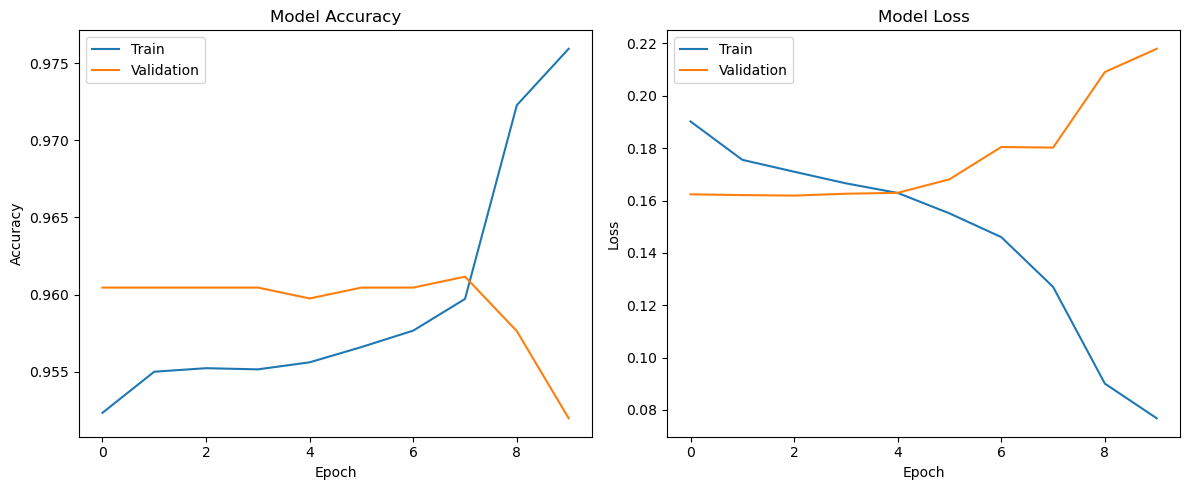

In [78]:
# File paths
train_features_path = 'data/feature_data/train_features.csv'
val_features_path = 'data/feature_data/val_features.csv'
test_features_path = 'data/feature_data/test_features.csv'

train_text_path = "data/train_sm.jsonl"
val_text_path = "data/validation_sm.jsonl"
test_text_path = "data/test_sm.jsonl"

MAX_SEQ_LEN = 100

try:
    
    # Load text data
    print("Loading text data...")
    train_text_data = preprocess_data(load_data(train_text_path))
    val_text_data = preprocess_data(load_data(val_text_path))
    test_text_data = preprocess_data(load_data(test_text_path))
    
    print(f"Train text data shape: {train_text_data.shape}")
    
    # Prepare data for model
    (train_embeddings, X_train_features, y_train, 
        val_embeddings, X_val_features, y_val, 
        test_embeddings, X_test_features, y_test,
        output_units, activation, loss, num_classes) = prepare_lstm_data(
        train_features_path, val_features_path, test_features_path,
        train_text_data, val_text_data, test_text_data,
        glove_embeddings, MAX_SEQ_LEN)
    
    # Build model
    embedding_shape = train_embeddings.shape[1:]  # (max_seq_len, embedding_dim)
    feature_shape = X_train_features.shape[1]     # Number of additional features
    
    model = build_lstm_model(embedding_shape, feature_shape)
    print(model.summary())
    
    # Train model
    model, history = train_model(
        model, 
        train_embeddings, X_train_features, y_train, 
        val_embeddings, X_val_features, y_val, 
        loss
    )
    
    # Evaluate model
    accuracy, macro_f1 = evaluate_model(model, test_embeddings, X_test_features, y_test, num_classes)
    
    # Save model
    model.save('lstm_text_classifier.h5')
    print("Model saved as 'lstm_text_classifier.h5'")
    
    # Plot training history
    try:
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        
        plt.tight_layout()
        plt.savefig('training_history.png')
        print("Training history plot saved as 'training_history.png'")
    except ImportError:
        print("Matplotlib not available. Skipping history plotting.")

except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback
    traceback.print_exc()